In [1]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

**1. Data preprocessing**

In [3]:
#Getting and loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/potatoleaves/potato_ds",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
#Getting the class names
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#The length of the dataset
len(dataset)

47

In [6]:
#A batch of 32 and each image has size of 256 * 256 pixels
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 0 0 0 1 2 1 1 1 2 0 0 2 0 0 0 1 2 0 0 0 2 1 2 2 0 2 0 1 2 2]


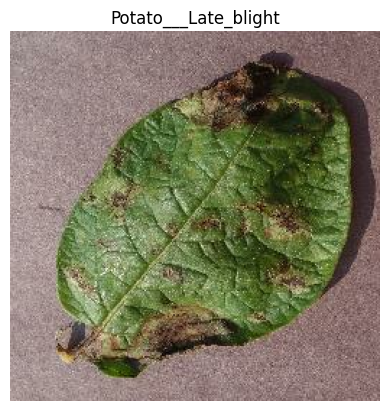

In [7]:
#Viewing one of the images
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

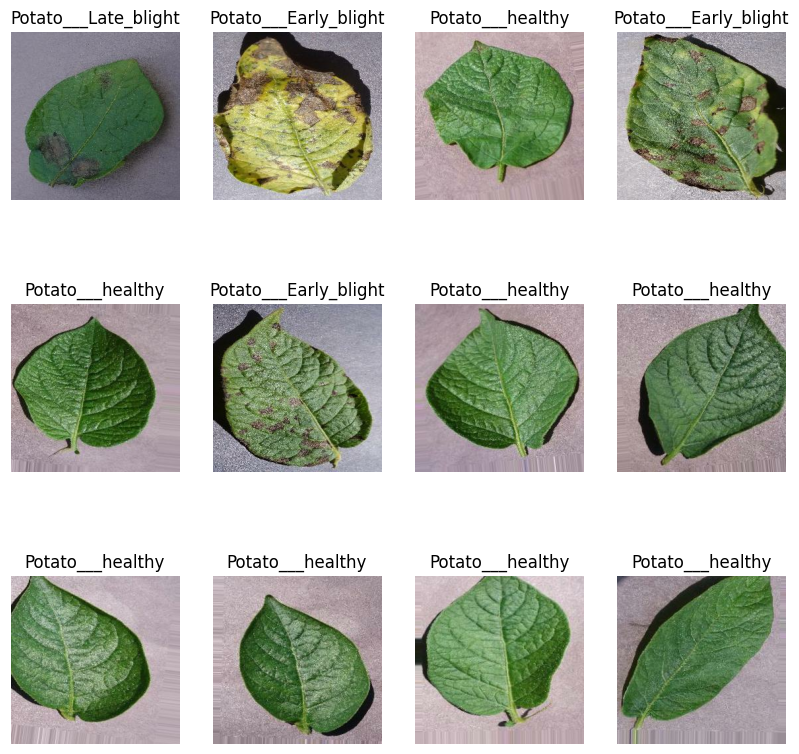

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

**2.** **Splitting the data**

In [9]:
#Getting the train size for the dataset
train_size = 0.8
len(dataset) * train_size

37.6

In [10]:
#Defining a function to split the dataset in tf
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = splitting_dataset_tf(dataset)

In [12]:
len(train_ds)

37

In [13]:
len(val_ds)

4

In [14]:
len(test_ds)

6

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#Scaling the dataset
scaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
#Using data augmentation for better performance
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**3. Model training**

**a. Model 1**

In [18]:
input = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model1 = models.Sequential([
    scaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model1.build(input_shape=input)

In [19]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model1.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
37/37 [==============================] - 174s 280ms/step - loss: 0.9925 - accuracy: 0.4492 - val_loss: 0.7371 - val_accuracy: 0.7891
Epoch 2/50
37/37 [==============================] - 2s 63ms/step - loss: 0.6764 - accuracy: 0.6898 - val_loss: 0.6692 - val_accuracy: 0.6094
Epoch 3/50
37/37 [==============================] - 2s 65ms/step - loss: 0.4753 - accuracy: 0.7788 - val_loss: 0.5988 - val_accuracy: 0.7656
Epoch 4/50
37/37 [==============================] - 2s 60ms/step - loss: 0.4221 - accuracy: 0.8263 - val_loss: 0.4090 - val_accuracy: 0.7969
Epoch 5/50
37/37 [==============================] - 2s 60ms/step - loss: 0.3594 - accuracy: 0.8585 - val_loss: 0.4406 - val_accuracy: 0.7812
Epoch 6/50
37/37 [==============================] - 2s 60ms/step - loss: 0.2965 - accuracy: 0.8847 - val_loss: 0.2013 - val_accuracy: 0.9219
Epoch 7/50
37/37 [==============================] - 2s 61ms/step - loss: 0.1953 - accuracy: 0.9373 - val_loss: 0.4733 - val_accuracy: 0.8203
Epoch 8/50

In [22]:
test_perf = model1.evaluate(test_ds)

6/6 [==============================] - 4s 28ms/step - loss: 0.1740 - accuracy: 0.9531


In [23]:
#Doing a plot to visualize the output

accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

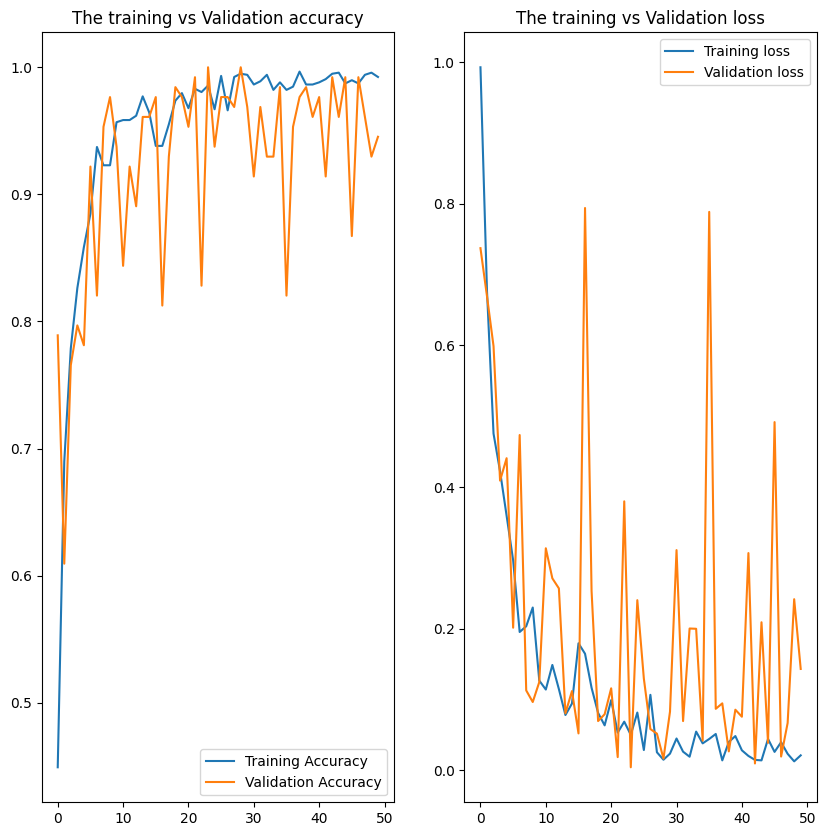

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(50), accu, label='Training Accuracy')
plt.plot(range(50), val_accu, label='Validation Accuracy')
plt.legend()
plt.title('The training vs Validation accuracy');

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training loss')
plt.plot(range(50), val_loss, label='Validation loss')
plt.legend()
plt.title('The training vs Validation loss');

First image to predict:
Actual label on dataset: Potato___Early_blight
1/1 [==============================] - 0s 158ms/step
Predicted label by model: Potato___Early_blight


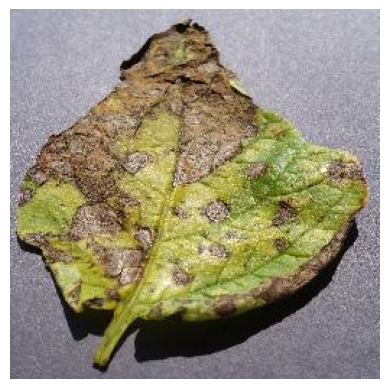

In [25]:
#Making a prediction
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  img_1 = images_batch[0].numpy().astype('uint8')
  img1_label = labels_batch[0].numpy()

  print('First image to predict:')
  plt.imshow(img_1)
  print('Actual label on dataset:', classes[img1_label])

  batch_prediction = model1.predict(images_batch)
  print('Predicted label by model:', classes[np.argmax(batch_prediction[0])])
  plt.axis("off")

In [26]:
#Doing more predictions

def predict(model1, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model1.predict(img_array)

  predicted_class = classes[np.argmax(predictions[0])]
  confidence_level = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence_level

1/1 [==============================] - 0s 19ms/step


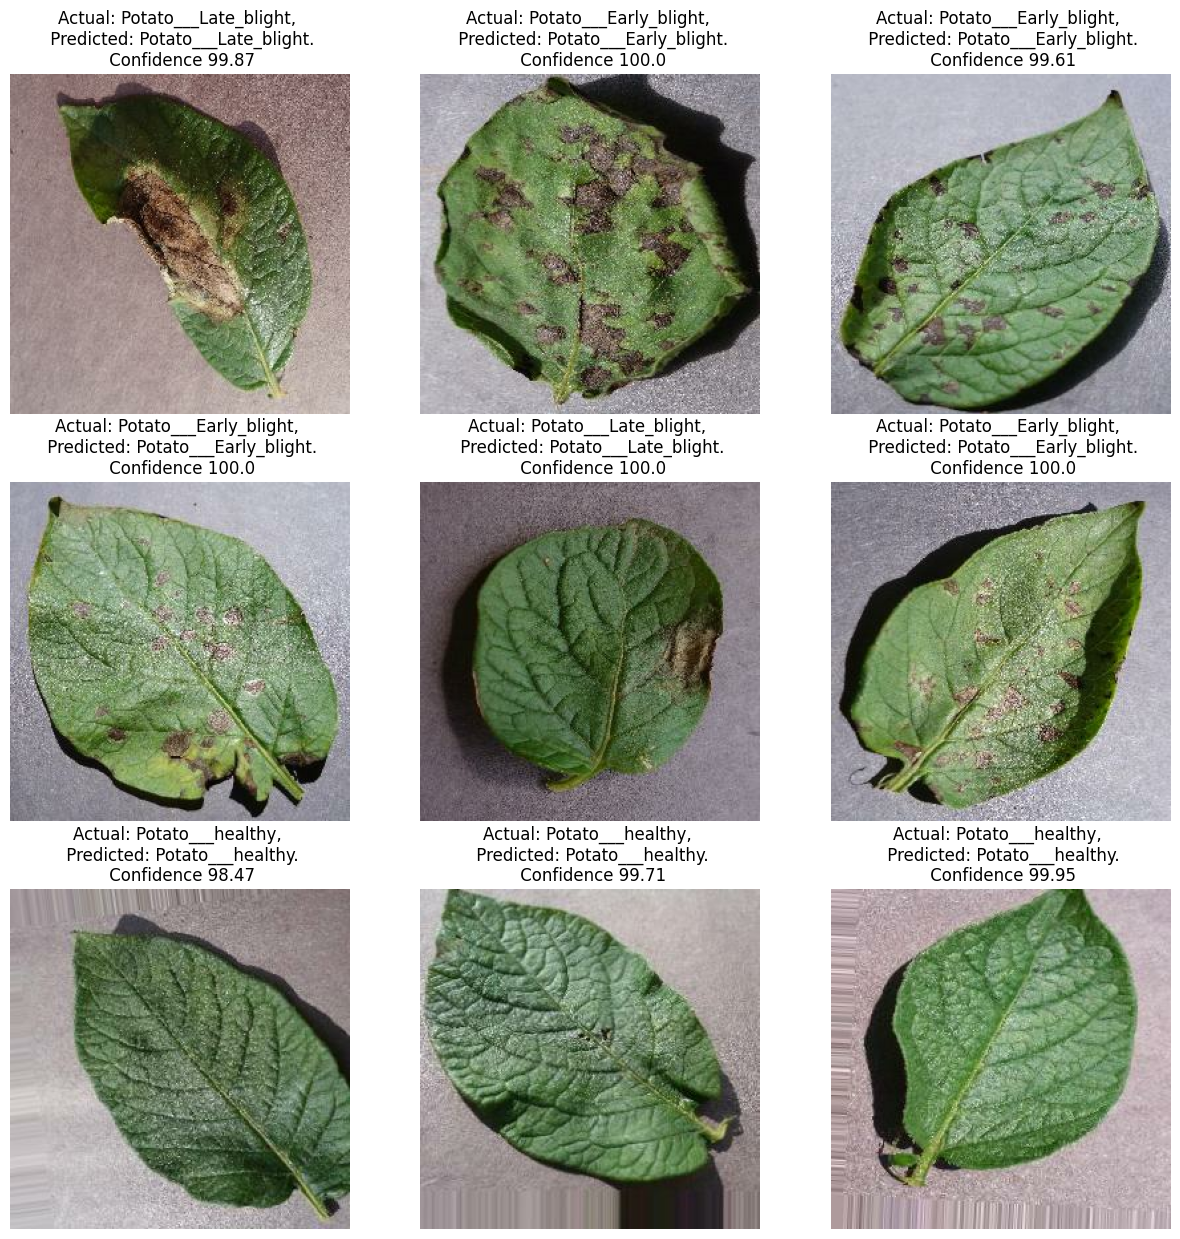

In [27]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence_level = predict(model1, images[i].numpy())
    actual_class = classes[labels[i]]

    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence {confidence_level}')
    plt.axis("off")

In [28]:
import pickle

with open('model1.pkl', 'wb') as f:
    pickle.dump(model1, f)

In [29]:
from keras.regularizers import l1
input = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model2 = models.Sequential([
    scaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input, kernel_regularizer=l1(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model2.build(input_shape=input)

In [30]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
model2.fit(
    train_ds,
    epochs=50,
    batch_size=32,
    validation_data=val_ds,
)

Epoch 1/50
37/37 [==============================] - 6s 68ms/step - loss: 0.9609 - accuracy: 0.5136 - val_loss: 0.7800 - val_accuracy: 0.6875
Epoch 2/50
37/37 [==============================] - 2s 61ms/step - loss: 0.5572 - accuracy: 0.7754 - val_loss: 0.5784 - val_accuracy: 0.7422
Epoch 3/50
37/37 [==============================] - 2s 61ms/step - loss: 0.4745 - accuracy: 0.8119 - val_loss: 0.3824 - val_accuracy: 0.8672
Epoch 4/50
37/37 [==============================] - 2s 64ms/step - loss: 0.3838 - accuracy: 0.8636 - val_loss: 0.3509 - val_accuracy: 0.8672
Epoch 5/50
37/37 [==============================] - 2s 63ms/step - loss: 0.3657 - accuracy: 0.8653 - val_loss: 0.2972 - val_accuracy: 0.8984
Epoch 6/50
37/37 [==============================] - 2s 61ms/step - loss: 0.3452 - accuracy: 0.8746 - val_loss: 0.2638 - val_accuracy: 0.8906
Epoch 7/50
37/37 [==============================] - 2s 61ms/step - loss: 0.2870 - accuracy: 0.8983 - val_loss: 0.3044 - val_accuracy: 0.8828
Epoch 8/50
37

First image to predict:
Actual label on dataset: Potato___healthy
1/1 [==============================] - 0s 34ms/step
Predicted label by model: Potato___healthy


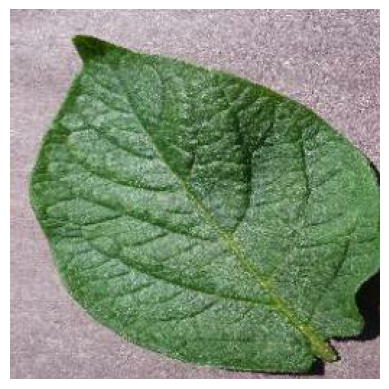

In [35]:
#Trying to make a prediction using model 2
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  img_1 = images_batch[0].numpy().astype('uint8')
  img1_label = labels_batch[0].numpy()

  print('First image to predict:')
  plt.imshow(img_1)
  print('Actual label on dataset:', classes[img1_label])

  batch_prediction = model2.predict(images_batch)
  print('Predicted label by model:', classes[np.argmax(batch_prediction[0])])
  plt.axis("off")

1/1 [==============================] - 0s 21ms/step


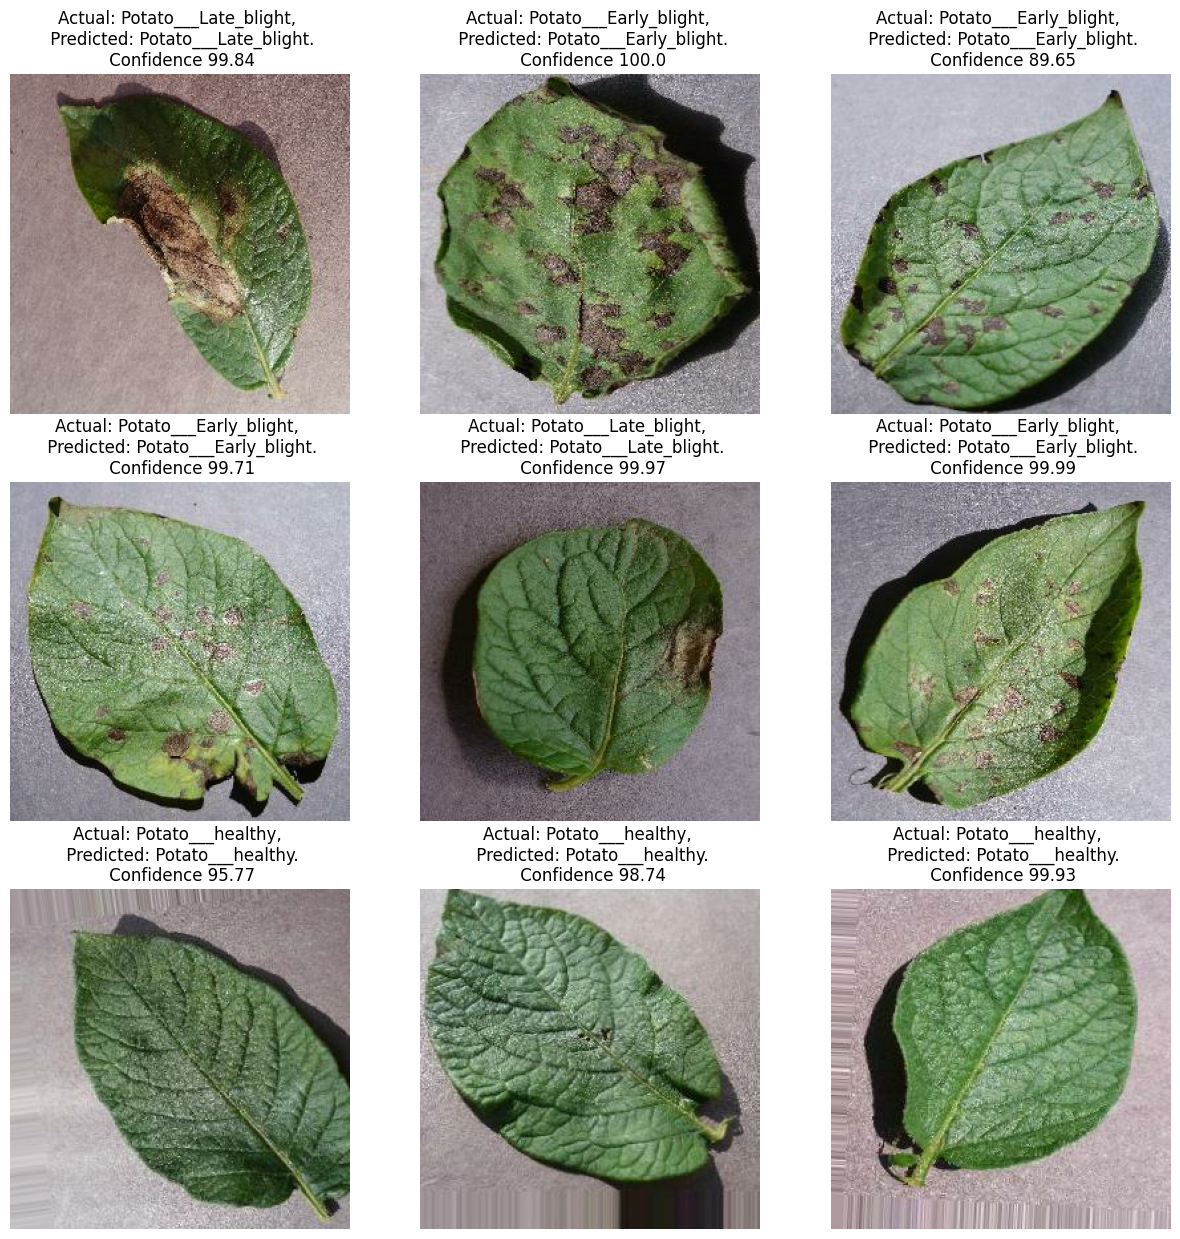

In [37]:
#Making predictions using second model

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence_level = predict(model2, images[i].numpy())
    actual_class = classes[labels[i]]

    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence {confidence_level}')
    plt.axis("off")